## Introduction
So far we have focused only on data preparation, without running any analysis or touching the stm package, which is what will happen here. In these paragraphs, we will initially focus on some diagnostic techniques for the identification of an adequate number of topics, which is a key step, and a question to which there is no "right" answer - or rather the answer is very context and needs-specific (see the <a href="https://cran.r-project.org/web/packages/stm/vignettes/stmVignette.pdf">stm package vignette </a> or the article by <a href="https://scholar.princeton.edu/sites/default/files/bstewart/files/stm.pdf">Roberts et al. 2016</a>). Secondly, we will perform some basic analysis on the resulting model, in order to understand more about it and to explore the potentialities of the stm package.

## Model selection

In the <a href="https://cran.r-project.org/web/packages/stm/stm.pdf">manual of the stm R package</a> the authors give some very generic rules of thumb in with regard to the number of topics:

> For short corpora focused on very specific subject matter (such as survey experiments) 3-10 topics is a useful starting range. For small corpora (a few hundred to a few thousand) 5-50 topics is a good place to start. Beyond these rough guidelines it is application specific. Previous applications in political science with medium sized corpora (10k to 100k documents) have found 60-100 topics to work well. For larger corpora 100 topics is a useful default size. Of course, your mileage may vary.

Ours is a small and short corpora on a relatively specific subject matter, so we shall focus at least initially on the 5-50 range. We will now explore some basic diagnostics to identify a properly fit model.

For the sake of the present exercise, we will focus on a model with only the factor by which the salary is computed as topic prevalence covariate. This was chosen by reasons of simplicity, as the other covariates need some further massaging, so we will work with them at a later stage. 

The "normal" dataframe needs to be converted into a matrix of word indeces and counts before being fed to the function. stm accepts different formats, among which quanteda dfm objects or sparse matrix, but here we will just use the native stm format prepared with the package functions <span style="font-family:Courier">textProcessor</span> and <span style="font-family:Courier">prepDocuments</span>:

In [2]:
suppressWarnings(library(stm))
suppressWarnings(library(stringr))

DF<-read.table("totaljobsCoordRates.txt")

DF<-DF[!is.na(DF$Description),]# stm doesn't work with missing data
DF<-DF[!is.na(DF$rateby),]

DF$Description = str_replace_all(DF$Description, "/"," ")# substitute "/" with a space  
DF$Description = str_replace_all(DF$Description, "&#x27;|&quot;|&#x2F;", "'") ## links and other eventual html encoding (adapted from https://juliasilge.com/blog/evaluating-stm/)
DF$Description = str_replace_all(DF$Description, "<a(.*?)>", " ")             ## 
DF$Description = str_replace_all(DF$Description, "&gt;|&lt;|&amp;", " ")      ##
DF$Description = str_replace_all(DF$Description, "&#[:digit:]+;", " ")        ##
DF$Description = str_remove_all(DF$Description, "<[^>]*>")

## textProcessor prepares the corpus, representing the documents as lists containting 
#word indicese and associated word counts, the vocab character vector associated with 
#the word indices and a metadata matrix containing the covariates. As we can remove some words, 
#here we opt to remove "work" and "will" from the corpus 

processed<-textProcessor(DF$Description, metadata = DF, customstopwords=c("work", "will"), verbose=FALSE)

##PrepDocuments is a helpful function to perform some manipulations like removing words based on thresholds 
#without compromising the indexes 
out<-prepDocuments(processed$documents, processed$vocab, processed$meta, verbose=FALSE)

docs<-out$documents
vocab<-out$vocab
meta<-out$meta

stm v1.3.3 (2018-1-26) successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com


As <span style="font-family:Courier">prepDocuments</span> removes words based on thresholds, it might be helfpul to have a cursory look at them. I found also helpful the below procedure to identify a specific document(s) where a specific word has been used.   

In [3]:
#identify documents where the word "heartland" has been used
wntword<-which(processed$vocab=="heartland")
filterdocs<-lapply(processed$documents, function(ch) grep(wntword, ch))
indexList<-filterdocs[sapply(filterdocs, function(x) length(x) > 0)]
DF[as.numeric(names(indexList)),]

OrdIndex Title                                       
199 199      Branch Customer Adviser - Hexham (Part Time)
    Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
199    The Societys branch network represents the face of Newcastle Building Society on the high street in our Heartland the North East of England. The main purpose of the branches is the provision of savings and mortgage accounts underpinned by solid Financial Advice for those who live in and around our branch locations, that are spread right across the North East of England, Cumbria and the Scottish borders. We deliver these services whilst providing excellent customer service. A priority for the branch network is maintaining great relationships with both existing and potential customers through maintaining regular customer engagement and being there to help them understand and address their ever changing financial needs. Role Summary This is a part-time position, 21 hours per week, Monday to Wednesday, 9am - 5pm (plus Saturday 8:45am-12:00pm, to be worked as overtime on a rota basis). You will consistently adopt a proactive and positive approach with our customers, in order to achieve the required business result. You will also understand how best to help customers by applying the branch understanding needs process, suggesting options customers may consider and identifying leads for the relevant advice specialists. You will be responsible for till operation, cash management, branch administration, servicing, balancing and cash replenishment. You will efficiently complete all administration in relation to customer enquiries, leads and sales, utilising the Societies customer management systems. Skills and Experience  As a Customer Adviser, you will be working as part of an already successful team that provides 1st class, market leading customer service. You will possess great communication skills that will result in high levels of customer satisfaction and customer advocacy for use of our products and services. A proven ability to work as part of a team and deliver the high standards we require is essentia

As mentioned above, with regards to the number of topics we should focus at least initially on the 5-50 range. stm allows to run some preliminary diagnostics in order to assess the models, in particular with the function <span style="font-family:Courier">searchK</span> which performs a number of tests, like held-out likelihood, residual analysis, average exclusivity and semantic coherence. The results then can be easily plotted just calling plot on the resulting searchK object. Those preferring to work with quanteda or sparse matrices can have a look at <a href="https://juliasilge.com/blog/evaluating-stm/">this</a> post by Julia Silge.

Here we will run a test on 5,10,15, 20 and 50 topics (note that the held-out is re-computed randomly with each run, so even with the same seed the results might be different).

In [4]:
storage1<-searchK(docs, vocab, K = c(5,10,15,20, 50), 
                 prevalence=~ rateby, data=meta,set.seed(9999), verbose=FALSE)

   K   exclus    semcoh   heldout residual     bound    lbound em.its
1  5 8.507777 -38.10020 -6.640414 1.724725 -445128.1 -445123.3     51
2 10 9.027609 -42.64086 -6.538232 1.509948 -431844.1 -431829.0     77
3 15 9.171255 -43.41021 -6.537566 1.395457 -425229.5 -425201.6     95
4 20 9.322676 -48.14587 -6.565082 1.411204 -419384.0 -419341.7     63
5 50 9.548999 -59.60185 -6.788529 2.653108 -396919.3 -396770.8     95


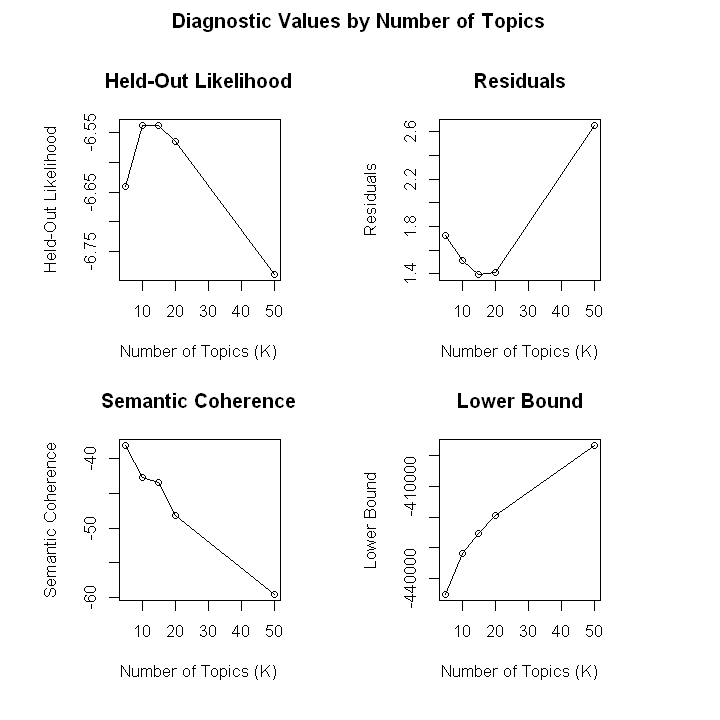

In [5]:
print(storage1$results)
options(repr.plot.width=6, repr.plot.height=6)
plot(storage1)

Within certain boundaries, it seems that the choice of model is a matter of trade-offs. In our case, the best results seem to be in the range 10-20, with 20 having the lowest residuals and highest held-out likelihood, at the cost of semantic coherence, which however tends normally to be better with a lower number of topics. It can be helpful to compare it to exclusivity, as models with fewer topics have higher semantic coherence for more topics, but lower exclusivity. To check for it however we have to fit the models first, which is what we do next. We will set the initiatlization method to the default "Spectral", as advised by the author of the package, although alternatives are available (the vignette offers further information about the different methods of initialization). Also in this case the post of Julia Silge mentioned above presents an alternative procedure.

In [6]:
model10Prrateby<-stm(documents=out$documents, 
                  vocab=out$vocab, prevalence =~ rateby, K=10, data=out$meta, init.type = "Spectral", verbose=FALSE)

model15Prrateby<-stm(documents=out$documents, 
                     vocab=out$vocab, prevalence =~ rateby, K=15, data=out$meta, init.type = "Spectral", verbose=FALSE)

model20Prrateby<-stm(documents=out$documents, 
                     vocab=out$vocab, prevalence =~ rateby, K=20, data=out$meta, init.type = "Spectral", verbose=FALSE)

As mentioned above, we check first exclusivity against semantic coherence per topic per model. stm includes the function <span style="font-family:Courier">topicQuality</span> to plot them per each model, but the visual result tends to be confusing and cannot plot multiple models together, so in this occasion we will proceed with ggplot and plotly:  

In [27]:
suppressWarnings(library(ggplot2))
suppressWarnings(library(plotly))
suppressWarnings(library(htmlwidgets))

M10ExSem<-as.data.frame(cbind(c(1:10),exclusivity(model10Prrateby), semanticCoherence(model=model10Prrateby, docs), "Mod10"))
M15ExSem<-as.data.frame(cbind(c(1:15),exclusivity(model15Prrateby), semanticCoherence(model=model15Prrateby, docs), "Mod15"))
M20ExSem<-as.data.frame(cbind(c(1:20),exclusivity(model20Prrateby), semanticCoherence(model=model20Prrateby, docs), "Mod20"))

ModsExSem<-rbind(M10ExSem, M15ExSem, M20ExSem)
colnames(ModsExSem)<-c("K","Exclusivity", "SemanticCoherence", "Model")

ModsExSem$Exclusivity<-as.numeric(as.character(ModsExSem$Exclusivity))
ModsExSem$SemanticCoherence<-as.numeric(as.character(ModsExSem$SemanticCoherence))

options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=100)

plotexcoer<-ggplot(ModsExSem, aes(SemanticCoherence, Exclusivity, color = Model))+geom_point(size = 2, alpha = 0.7) + 
geom_text(aes(label=K), nudge_x=.05, nudge_y=.05)+
  labs(x = "Semantic coherence",
       y = "Exclusivity",
       title = "Comparing exclusivity and semantic coherence")

#p<-ggplotly(plotexcoer)
#embed_notebook(p)
#htmlwidgets::saveWidget(p, "ExclCoer.html")
as_widget(ggplotly(plotexcoer))



We recommend that you use the dev version of ggplot2 with `ggplotly()`
Install it with: `devtools::install_github('hadley/ggplot2')`


HTML widgets cannot be represented in plain text (need html)

The three models appear fairly similar in this regard, with the model with 20 topics having two outliers with relatively lower semantic coherence and the model with 10 topics with the tendence to have lower exclusivity. For the sake of the present exercise we will then proceed with the model with 15 topics, which appears to be a good compromise. On the other hand, the other two models can be considered good enough and in another situation they might be preferrable. As mentioned above, the choice of the model can be very context-specific.

## Model analysis

Next, we want to know a bit better our model. stm stores the document-topic proportions and the topic-word distributions in two matrices, $\theta$ (which is also refferred to, somewhat confusingly, as $\gamma$) and $\beta$.   

We shall start having a look at $\theta$, which can be called directly from the model, or more conveniently with the built-in function <span style="font-family:Courier">make.dt</span>, which allows to load also the metadata (which in our case is helpful considering we used rateby as prevalence co-variate).

In [8]:
topicprop15<-make.dt(model15Prrateby, meta)
topicprop15[1:3,c(1:18, 27)]#visualize proportions, job title and rateby

docnum Topic1      Topic2      Topic3       Topic4       Topic5      
1 1      0.011672020 0.023733125 0.0003485387 8.557529e-02 0.0105680973
2 2      0.844911636 0.028214366 0.0004880101 7.751244e-05 0.0005705033
3 3      0.001695485 0.002248965 0.0056817043 1.250004e-02 0.0072944425
  Topic6       Topic7       Topic8       Topic9      Topic10      Topic11    
1 0.0072089073 0.0020970495 0.1369500597 0.713769152 2.393135e-05 0.002362233
2 0.0001128912 0.1113556777 0.0003121456 0.005859538 8.466792e-05 0.004929355
3 0.6280678449 0.0007401341 0.0009744490 0.001820794 4.343501e-03 0.299613163
  Topic12      Topic13      Topic14      Topic15     OrdIndex
1 0.0000192910 0.0032763198 0.0006509655 0.001745020 1       
2 0.0005816675 0.0008155772 0.0005323473 0.001154104 2       
3 0.0007912304 0.0033426930 0.0207345580 0.010150995 3       
  Title                                 rateby
1 Dementia Friendly Communities Officer  year 
2 Healthcare Assistant                  hour  
3 Accounts Assistant                     year

Consulting the table might be quite cumbersome unless you want to have a look at the topic proportions of a specific document. stm offers the <span style="font-family:Courier">plot.STM</span> function with "hist" as argument in order to visualize the estimates of document-topic proportions (Julia Silge in <a href="https://juliasilge.com/blog/sherlock-holmes-stm/">another post </a> offers a different procedure using ggplot to otbain a similar plot, I have included this in the appendix): 

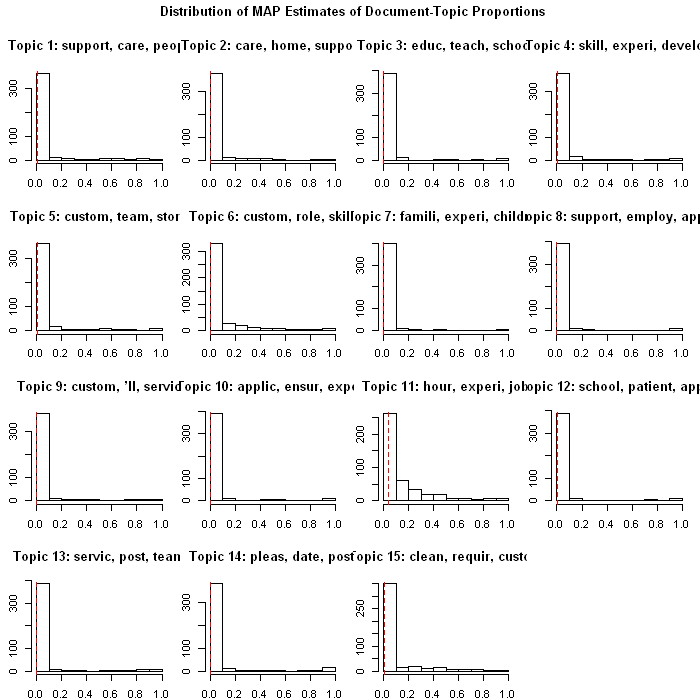

In [9]:
options(repr.plot.width=7, repr.plot.height=7)

plot.STM(model15Prrateby, "hist")

This plot basically tells us which topics are coming from which documents. As expected, each topic has no relation or very little relation with several documents. I personally found also helpful to plot the topic distribution per document, using tidytext and ggplot:

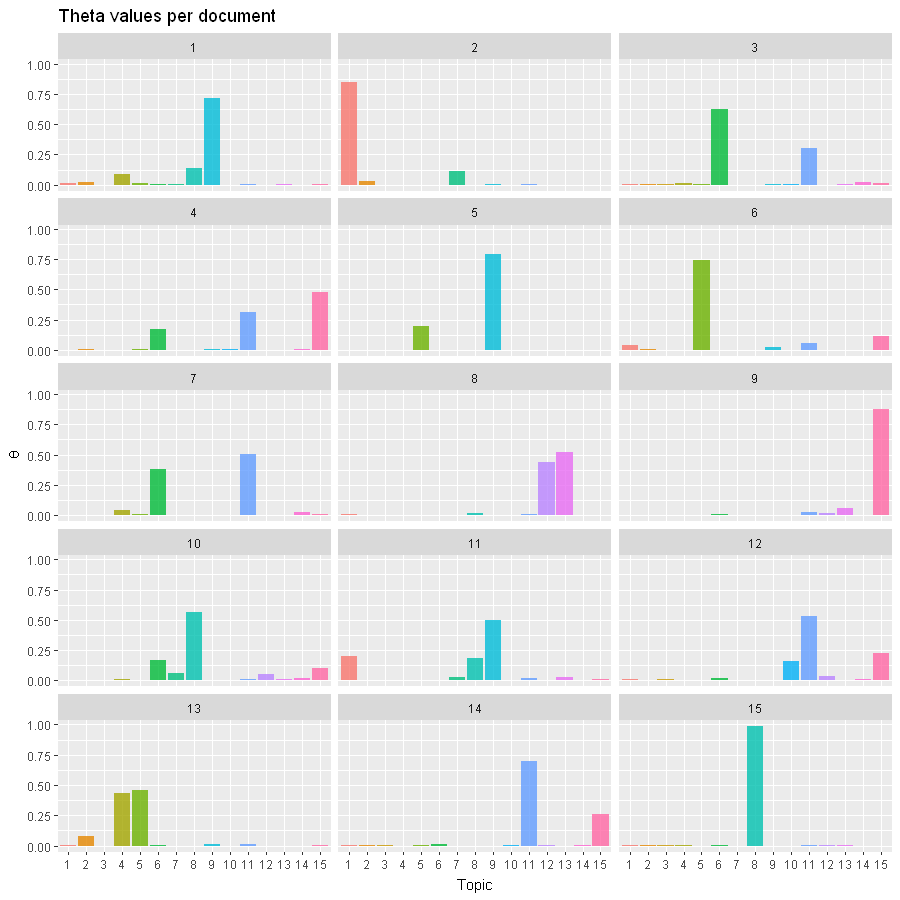

In [10]:
suppressWarnings(library(tidytext))# the package sometimes is not loaded correctly. If this happens, you might have to re-start the kernel 
td_theta <- tidytext::tidy(model15Prrateby, matrix = "theta")

selectiontdthteta<-td_theta[td_theta$document%in%c(1:15),]#select the first 30 documents. be careful to select a sensible interval, as attempting to load a very huge corpus might crash the kernel

thetaplot1<-ggplot(selectiontdthteta, aes(y=gamma, x=as.factor(topic), fill = as.factor(topic))) +
  geom_bar(stat="identity",alpha = 0.8, show.legend = FALSE) +
  facet_wrap(~ document, ncol = 3) +
  labs(title = "Theta values per document",
       y = expression(theta), x = "Topic")

options(repr.plot.width=9, repr.plot.height=9, repr.plot.res=100)
thetaplot1


As an example, we see here that document 9 is strongly associated with topic 15 and document 15 with topic 8, whereas documents 10 or 13 are more mixed. 

Next, we want to understand more about each topic - what are they really about. If we go back to the $\beta$ matrix, we can have a more analytical look at the word frequencies per topic. The matrix stores the log of the word probabilities for each topic, and plotting it can give us a good overall understanding of the distribution of words per topic (the procedure below is mutuated from the <a href="https://juliasilge.com/blog/sherlock-holmes-stm/">  second post of Julia Silge </a>): 


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'bindrcpp' was built under R version 3.4.3"

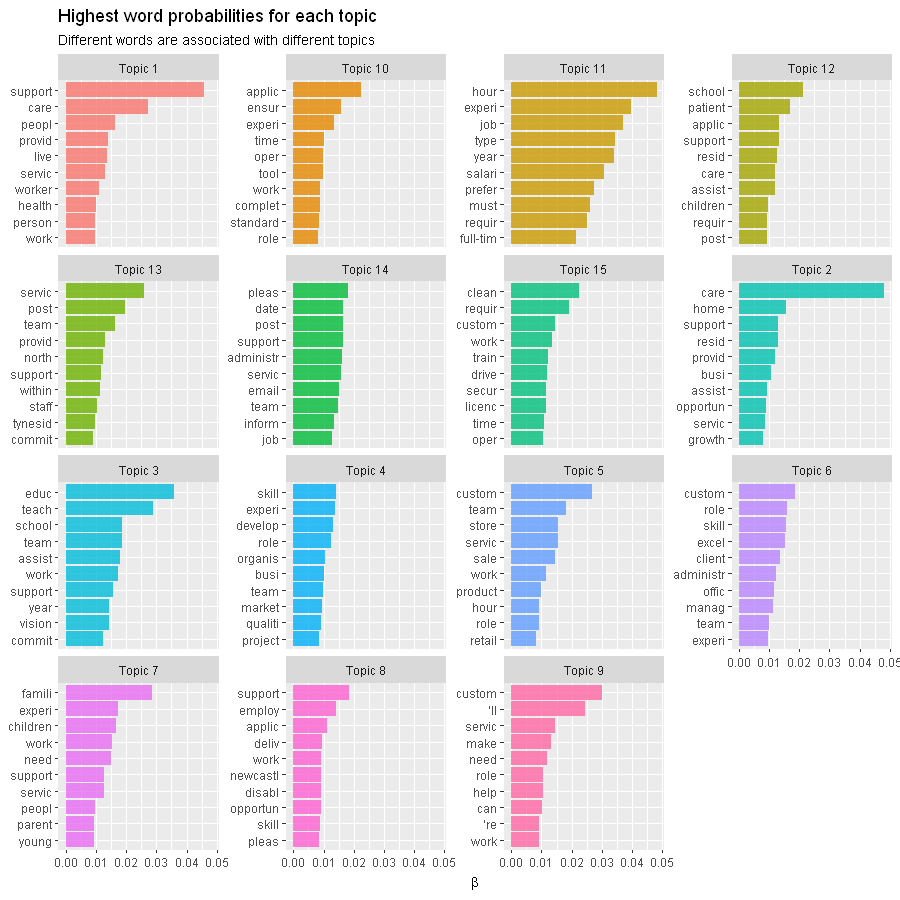

In [11]:
suppressWarnings(library(dplyr))
suppressWarnings(library(drlib))#drlib is available on github and needs devtools to be installed

td_beta <- tidytext::tidy(model15Prrateby)

options(repr.plot.width=9, repr.plot.height=9, repr.plot.res=100)

td_beta %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
 ungroup() %>%
    mutate(topic = paste0("Topic ", topic),
         term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = as.factor(topic))) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free_y") +
  coord_flip() +
  scale_x_reordered() +
  labs(x = NULL, y = expression(beta),
       title = "Highest word probabilities for each topic",
       subtitle = "Different words are associated with different topics")

In this case I found pretty helpful to go and have a more detailed look at the word distribution within each topic (the plot above focus only on the top 10 words for each topic):

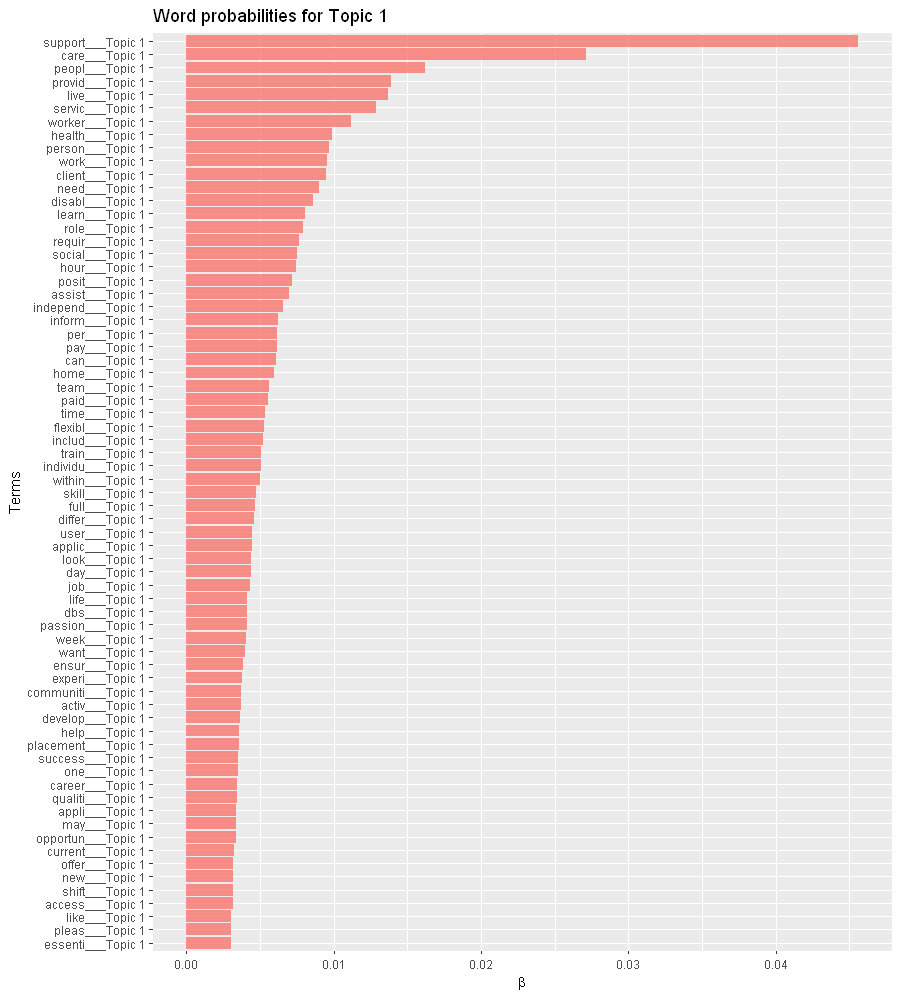

In [12]:
betaT1<-td_beta %>%
  mutate(topic = paste0("Topic ", topic),
         term = reorder_within(term, beta, topic)) %>%filter(topic=="Topic 1")#beta values for topic 1

betaplotT1<-ggplot(betaT1[betaT1$beta>0.003,], aes(term, beta, fill = as.factor(topic))) +
  geom_bar(alpha = 0.8, show.legend = FALSE, stat = "Identity")+coord_flip()+labs(x ="Terms", y = expression(beta),
       title = "Word probabilities for Topic 1")#plot word probabilities higher than 0.003 for topic 1

options(repr.plot.width=9, repr.plot.height=10, repr.plot.res=100)
betaplotT1

Also for topic exploration the stm package offers some nice built-in functions that make analysis easier. In order to identify the content of each topic, we can use again <span style="font-family:Courier">plot.STM</span>, this time with argument "summary" to visualize the topic distribution (which topics are overall more common), with most common words for each topic (as we will see later there are several options for the words to be visualized, but here we will leave the default). 

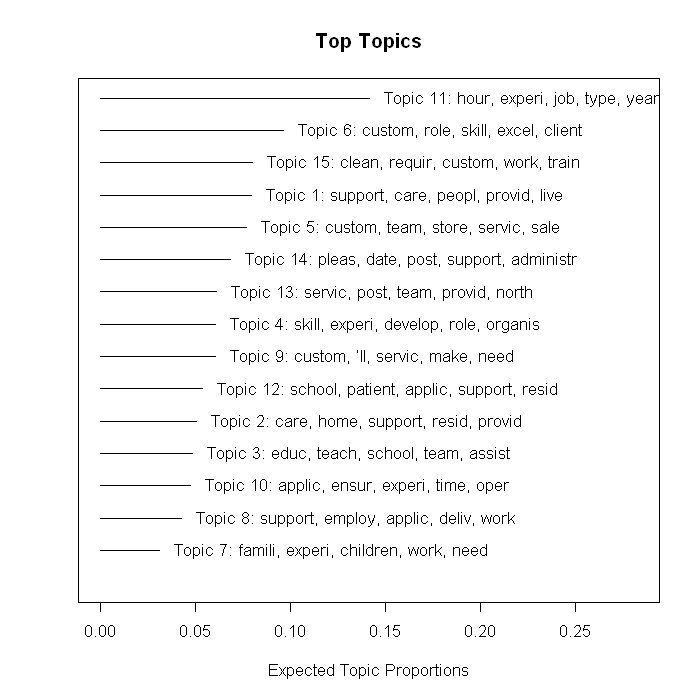

In [13]:
options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=100)
plot.STM(model15Prrateby, "summary", n=5)# distribution and top 5 words per topic

<span style="font-family:Courier">labelTopics</span> (or <span style="font-family:Courier">sageLabels</span>) gives us  more detailed insights on the popular words in each topic. As mentioned above, other than the highest probability, we can visualize the FREX words (FREX weights words by frequency and exclusivity to the topic), lift words (frequency divided by frequency in other topics), and score (similar to lift, but with log frequencies). The vignette and the manual of stm offer more details on this aspect. <span style="font-family:Courier">plot.STM</span> can again be used with "labels" as argument to plot the words in a more visually appealing way (although I found the final result not always satisfactory).

This type of analyis can be helpful in particular to make comparisons between topics and understand more which differences there are between them. As an example, topics 5,6,9 seem to have a degree of overlap, as they are all focusing on customer care, so we might want to check them in more detail: 

Topic 5 Top Words:
 	 Highest Prob: custom, team, store, servic, sale, work, product, hour, role, retail 
 	 FREX: store, retail, sale, love, kitchen, brand, product, great, discount, price 
 	 Lift: can, afford, ambassador, here, high-street, lowest, merchandis, pub, sister, tvs 
 	 Score: store, sale, saver, custom, superdrug, retail, bike, fashion, kitchen, love 
Topic 6 Top Words:
 	 Highest Prob: custom, role, skill, excel, client, administr, offic, manag, team, experi 
 	 FREX: order, invoic, purchas, supplier, administr, detail, client, manufactur, tax, verbal 
 	 Lift: bill, bullet, coleman, courier, expedit, fork, forklift, inventori, law, louis 
 	 Score: sale, purchas, invoic, custom, manufactur, adecco, stock, ledger, angel, global 
Topic 9 Top Words:
 	 Highest Prob: custom, ll, servic, make, need, role, help, can, re, work 
 	 FREX: ll, re, just, everyon, thing, dont, realli, want, legal, get 
 	 Lift: bag, colour, discrimin, forget, moment, offici, optic, perhap, 

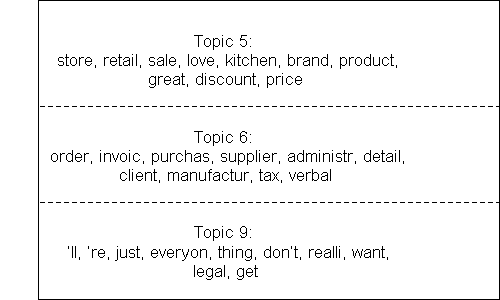

In [14]:
labelTopics(model15Prrateby, topics=c(5,6,9), n=10)# complete list of top 10 words per topics 5-6-9

par(mfrow=c(1,1), mar=c(0,2,0,0))
options(repr.plot.width=5, repr.plot.height=3, repr.plot.res=100)
plot.STM(model15Prrateby, "labels", topics=c(5,6,9), label="frex", n=10, width=55)#top 10 FREX words per topics 5-6-9

We can also have a glimpse at highly representative documents per each topic with <span style="font-family:Courier">findThoughts</span>, and plot them with <span style="font-family:Courier">plotQuote</span> (although this might give best results with shorter documents):

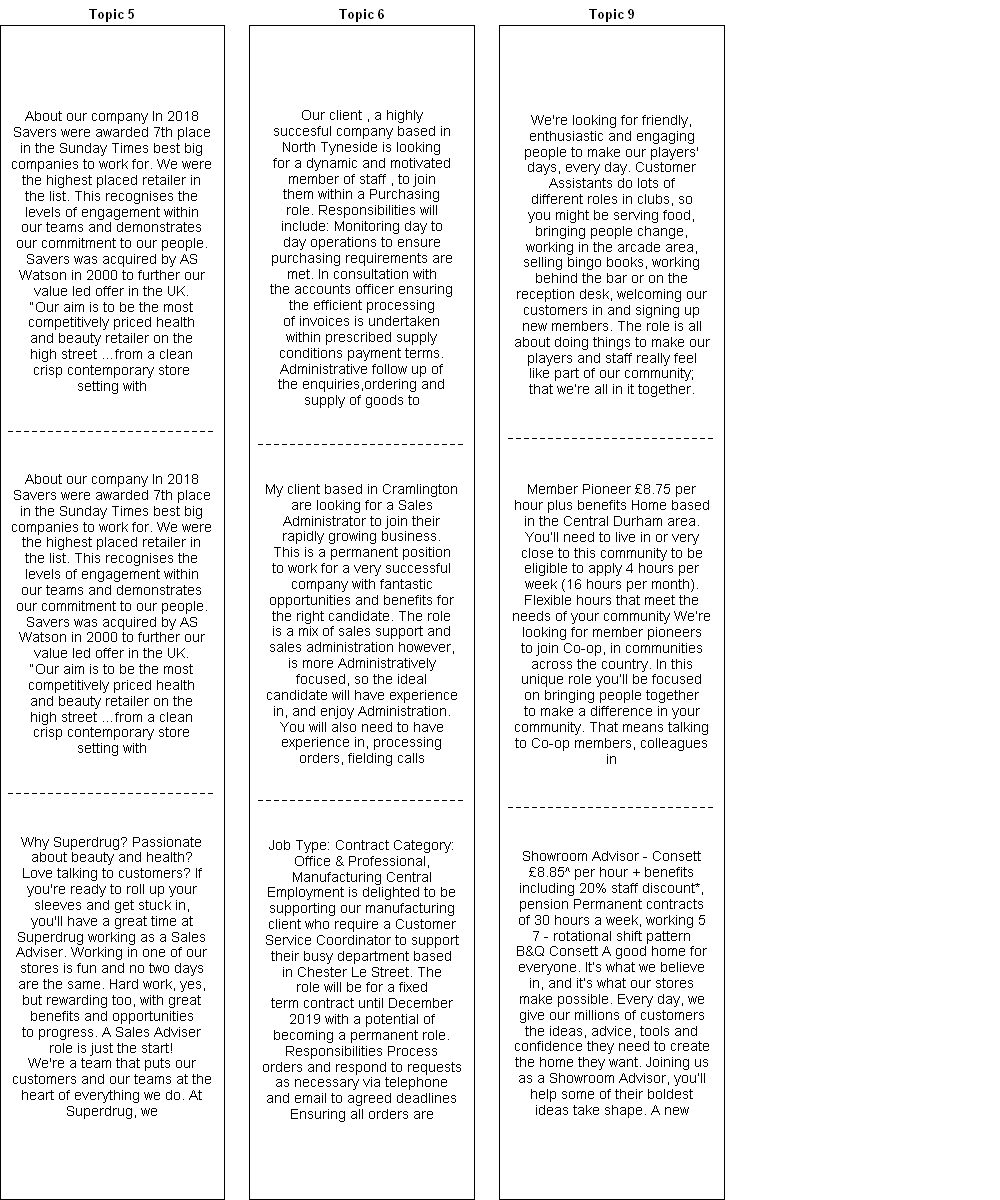

In [15]:
thoughts5 <- findThoughts(model15Prrateby,texts=DF$Description, topics=5, n=3)$docs[[1]]# take  3 representative documents per topic 5
thoughts6 <- findThoughts(model15Prrateby,texts=DF$Description, topics=6, n=3)$docs[[1]]# take  3 representative documents per topic 6
thoughts9 <- findThoughts(model15Prrateby,texts=DF$Description, topics=9, n=3)$docs[[1]]# take  3 representative documents per topic 9

options(repr.plot.width=10, repr.plot.height=12, repr.plot.res=100)
par(mfrow=c(1,4), mar=c(0,0,2,2))

plotQuote(thoughts5, width=30, maxwidth=500, text.cex=1.25, main="Topic 5")
plotQuote(thoughts6, width=30, maxwidth=500, text.cex=1.25, main="Topic 6")
plotQuote(thoughts9, width=30, maxwidth=500, text.cex=1.25, main="Topic 9")

We might assume that topic 5 is more related to retail, with positions like store assistant, topic 6 closer to back office and sales positions and topic 9 somewhere in between. It is worth noting that several words in topic 9 seem to have weak semantic content (like "'ll", "'re", "'just"), and we might consider to re-run the model taking them out as stopwords. If we go back to the distribution of estimates, very few documents seem to have a strong association with topic 9, and if we recover the original exclusivity-semantic coherence plot, we note that topic 9 has the lowest exclusivity in the model we are using: 

In [16]:
embed_notebook(p)

<iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+DQo8aHRtbD4NCjxoZWFkPg0KPG1ldGEgY2hhcnNldD0idXRmLTgiIC8+DQo8dGl0bGU+cGxvdGx5PC90aXRsZT4NCjxzY3JpcHQgc3JjPSJkYXRhOmFwcGxpY2F0aW9uL3gtamF2YXNjcmlwdDtiYXNlNjQsS0daMWJtTjBhVzl1S0NrZ2V3b2dJQzh2SUVsbUlIZHBibVJ2ZHk1SVZFMU1WMmxrWjJWMGN5QnBjeUJoYkhKbFlXUjVJR1JsWm1sdVpXUXNJSFJvWlc0Z2RYTmxJR2wwT3lCdmRHaGxjbmRwYzJVZ1kzSmxZWFJsSUdFS0lDQXZMeUJ1WlhjZ2IySnFaV04wTGlCVWFHbHpJR0ZzYkc5M2N5QndjbVZqWldScGJtY2dZMjlrWlNCMGJ5QnpaWFFnYjNCMGFXOXVjeUIwYUdGMElHRm1abVZqZENCMGFHVUtJQ0F2THlCcGJtbDBhV0ZzYVhwaGRHbHZiaUJ3Y205alpYTnpJQ2gwYUc5MVoyZ2dibTl1WlNCamRYSnlaVzUwYkhrZ1pYaHBjM1FwTGdvZ0lIZHBibVJ2ZHk1SVZFMU1WMmxrWjJWMGN5QTlJSGRwYm1SdmR5NUlWRTFNVjJsa1oyVjBjeUI4ZkNCN2ZUc0tDaUFnTHk4Z1UyVmxJR2xtSUhkbEozSmxJSEoxYm01cGJtY2dhVzRnWVNCMmFXVjNaWElnY0dGdVpTNGdTV1lnYm05MExDQjNaU2R5WlNCcGJpQmhJSGRsWWlCaWNtOTNjMlZ5TGdvZ0lIWmhjaUIyYVdWM1pYSk5iMlJsSUQwZ2QybHVaRzkzTGtoVVRVeFhhV1JuWlhSekxuWnBaWGRsY2sxdlpHVWdQUW9nSUNBZ0lDQXZYR0oyYVdWM1pYSmZjR0Z1WlQweFhHSXZMblJsYzNRb2QybHVaRzkzTG14dlkyRjBhVzl1S1RzS0NpQWdMeThnVTJWbElHbG1JSGRsSjNKbElISjFibTVwYm1jZ2FXNGdVMmhwYm5rZ2JXOWtaUzRnU1dZZ2JtOTBMQ0JwZENkeklHRWdjM1JoZEdsaklHUnZZM1Z0Wlc1MExnb2dJQzh2SUU1dmRHVWdkR2hoZENCemRHRjBhV01nZDJsa1oyVjBjeUJqWVc0Z1lYQndaV0Z5SUdsdUlHSnZkR2dnVTJocGJua2dZVzVrSUhOMFlYUnBZeUJ0YjJSbGN5d2dZblYwQ2lBZ0x5OGdiMkoyYVc5MWMyeDVMQ0JUYUdsdWVTQjNhV1JuWlhSeklHTmhiaUJ2Ym14NUlHRndjR1ZoY2lCcGJpQlRhR2x1ZVNCaGNIQnpMMlJ2WTNWdFpXNTBjeTRLSUNCMllYSWdjMmhwYm5sTmIyUmxJRDBnZDJsdVpHOTNMa2hVVFV4WGFXUm5aWFJ6TG5Ob2FXNTVUVzlrWlNBOUNpQWdJQ0FnSUhSNWNHVnZaaWgzYVc1a2IzY3VVMmhwYm5rcElDRTlQU0FpZFc1a1pXWnBibVZrSWlBbUppQWhJWGRwYm1SdmR5NVRhR2x1ZVM1dmRYUndkWFJDYVc1a2FXNW5jenNLQ2lBZ0x5OGdWMlVnWTJGdUozUWdZMjkxYm5RZ2IyNGdhbEYxWlhKNUlHSmxhVzVuSUdGMllXbHNZV0pzWlN3Z2MyOGdkMlVnYVcxd2JHVnRaVzUwSUc5MWNpQnZkMjRLSUNBdkx5QjJaWEp6YVc5dUlHbG1JRzVsWTJWemMyRnllUzRLSUNCbWRXNWpkR2x2YmlCeGRXVnllVk5sYkdWamRHOXlRV3hzS0hOamIzQmxMQ0J6Wld4bFkzUnZjaWtnZXdvZ0lDQWdhV1lnS0hSNWNHVnZaaWhxVVhWbGNua3BJQ0U5UFNBaWRXNWtaV1pwYm1Wa0lpQW1KaUJ6WTI5d1pTQnBibk4wWVc1alpXOW1JR3BSZFdWeWVTa2dld29nSUNBZ0lDQnlaWFIxY200Z2MyTnZjR1V1Wm1sdVpDaHpaV3hsWTNSdmNpazdDaUFnSUNCOUNpQWdJQ0JwWmlBb2MyTnZjR1V1Y1hWbGNubFRaV3hsWTNSdmNrRnNiQ2tnZXdvZ0lDQWdJQ0J5WlhSMWNtNGdjMk52Y0dVdWNYVmxjbmxUWld4bFkzUnZja0ZzYkNoelpXeGxZM1J2Y2lrN0NpQWdJQ0I5Q2lBZ2ZRb0tJQ0JtZFc1amRHbHZiaUJoYzBGeWNtRjVLSFpoYkhWbEtTQjdDaUFnSUNCcFppQW9kbUZzZFdVZ1BUMDlJRzUxYkd3cENpQWdJQ0FnSUhKbGRIVnliaUJiWFRzS0lDQWdJR2xtSUNna0xtbHpRWEp5WVhrb2RtRnNkV1VwS1FvZ0lDQWdJQ0J5WlhSMWNtNGdkbUZzZFdVN0NpQWdJQ0J5WlhSMWNtNGdXM1poYkhWbFhUc0tJQ0I5Q2dvZ0lDOHZJRWx0Y0d4bGJXVnVkQ0JxVVhWbGNua25jeUJsZUhSbGJtUUtJQ0JtZFc1amRHbHZiaUJsZUhSbGJtUW9kR0Z5WjJWMElDOHFMQ0F1TGk0Z0tpOHBJSHNLSUNBZ0lHbG1JQ2hoY21kMWJXVnVkSE11YkdWdVozUm9JRDA5SURFcElIc0tJQ0FnSUNBZ2NtVjBkWEp1SUhSaGNtZGxkRHNLSUNBZ0lIMEtJQ0FnSUdadmNpQW9kbUZ5SUdrZ1BTQXhPeUJwSUR3Z1lYSm5kVzFsYm5SekxteGxibWQwYURzZ2FTc3JLU0I3Q2lBZ0lDQWdJSFpoY2lCemIzVnlZMlVnUFNCaGNtZDFiV1Z1ZEhOYmFWMDdDaUFnSUNBZ0lHWnZjaUFvZG1GeUlIQnliM0FnYVc0Z2MyOTFjbU5sS1NCN0NpQWdJQ0FnSUNBZ2FXWWdLSE52ZFhKalpTNW9ZWE5QZDI1UWNtOXdaWEowZVNod2NtOXdLU2tnZXdvZ0lDQWdJQ0FnSUNBZ2RHRnlaMlYwVzNCeWIzQmRJRDBnYzI5MWNtTmxXM0J5YjNCZE93b2dJQ0FnSUNBZ0lIMEtJQ0FnSUNBZ2ZRb2dJQ0FnZlFvZ0lDQWdjbVYwZFhKdUlIUmhjbWRsZERzS0lDQjlDZ29nSUM4dklFbEZPQ0JrYjJWemJpZDBJSE4xY0hCdmNuUWdRWEp5WVhrdVptOXlSV0ZqYUM0S0lDQm1kVzVqZEdsdmJpQm1iM0pGWVdOb0tIWmhiSFZsY3l3Z1kyRnNiR0poWTJzc0lIUm9hWE5CY21jcElIc0tJQ0FnSUdsbUlDaDJZV3gxWlhNdVptOXlSV0ZqYUNrZ2V3b2dJQ0FnSUNCMllXeDFaWE11Wm05eVJXRmphQ2hqWVd4c1ltRmpheXdnZEdocGMwRnlaeWs3Q2lBZ0lDQjlJR1ZzYzJVZ2V3b2dJQ0FnSUNCbWIzSWdLSFpoY2lCcElEMGdNRHNnYVNBOElIWmhiSFZsY3k1c1pXNW5kR2c3SUdrckt5a2dld29nSUNBZ0lDQWdJR05oYkd4aVlXTnJMbU5oYkd3b2RHaHBjMEZ5Wnl3Z2RtRnNkV1Z6VzJsZExDQnBMQ0IyWVd4MVpYTXBPd29nSUNBZ0lDQjlDaUFnSUNCOUNpQWdmUW9LSUNBdkx5QlNaWEJzWVdObGN5QjBhR1VnYzNCbFkybG1hV1ZrSUcxbGRHaHZaQ0IzYVhSb0lIUm9aU0J5WlhSMWNtNGdkbUZzZFdVZ2IyWWdablZ1WTFOdmRYSmpaUzRLSUNBdkx3b2dJQzh2SUU1dmRHVWdkR2hoZENCbWRXNWpVMjkxY21ObElITm9iM1ZzWkNCdWIzUWdRa1VnZEdobElHNWxkeUJ0WlhSb2IyUXNJR2wwSUhOb2IzVnNaQ0JpWlNCaElHWjFibU4wYVc5dUNpQWdMeThnZEdoaGRDQlNSVlJ

Another very helpful function to use for topic analysis is again <span style="font-family:Courier">plot.STM</span> with "perspectives" as  argument, wich allows us to have a graphical display of topical contrasts, where words are plotted with size proportional to their use within the topic and oriented along the X-axis based on how much they favor one topic against the other (the vertical configuration is random):

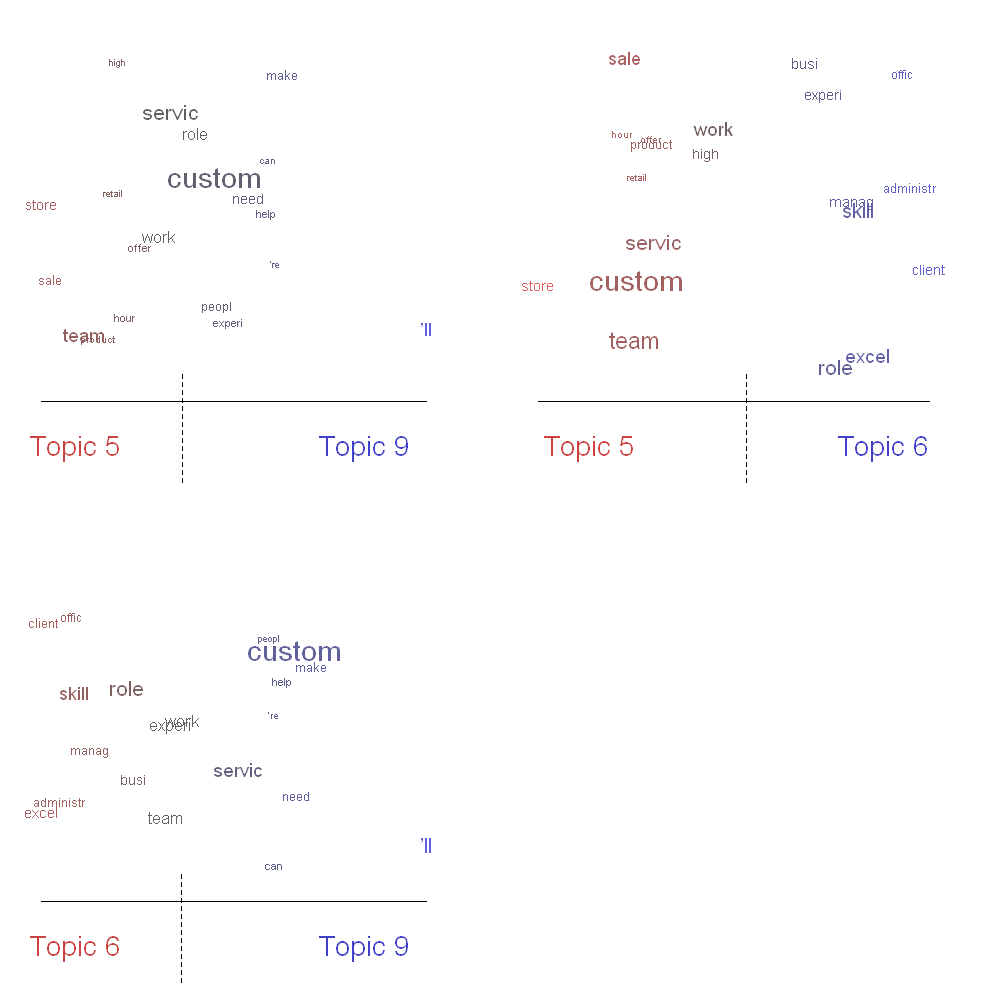

In [17]:
options(repr.plot.width=10, repr.plot.height=10, repr.plot.res=100)
par(mfrow=c(2,2), mar=c(0,0,2,2))

plot.STM(model15Prrateby, "perspectives", topics=c(5,9))
plot.STM(model15Prrateby, "perspectives", topics=c(5,6))
plot.STM(model15Prrateby, "perspectives", topics=c(6,9))

Our supposition about the differences between topic 6 and 5 seems confirmed, while the topic 9 is confirmed to have a weak semantic content. We will probably have to re-run the model taking out some additional stopwords. However, we can first conclude this overview of the main functions of stm having a look at the difference made by the inclusion of "rateby" as a topic prevalence co-variate. As mentioned in a previous post, the Structural Topic Model allows the analysis of relationships with document metadata, in form of co-variates, either in terms of the degree of association of a document to a topic, either of the association of a word to a topic. The function to extract the relationship and associated uncertaintuy on all the topics of the model is <span style="font-family:Courier">estimateEffect</span>, which basically estimates a regression with documents as units, the outcome is the proportion of each document about a topic in an STM model and the covariates are document-meta data:

In [18]:
out$meta$rateby<-as.factor(out$meta$rateby)
prep<-estimateEffect(1:15~ rateby, model15Prrateby, metadata=out$meta, uncertainty="Global")#nsim is defaulted to 25, but on a small model a higher number lead to more consistent results
summary(prep, topics=c(1:3), nsim=1000)# summary of regression on topic 1-3


Call:
estimateEffect(formula = 1:15 ~ rateby, stmobj = model15Prrateby, 
    metadata = out$meta, uncertainty = "Global")


Topic 1:

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.038627   0.014147   2.730 0.006591 ** 
ratebyday    0.032239   0.047443   0.680 0.497173    
ratebyhour   0.070130   0.021027   3.335 0.000928 ***
ratebymonth -0.007743   0.196373  -0.039 0.968567    
ratebyweek  -0.038786   0.059962  -0.647 0.518087    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Topic 2:

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.03968    0.01421   2.793  0.00547 **
ratebyday   -0.02253    0.04140  -0.544  0.58650   
ratebyhour   0.03338    0.01894   1.763  0.07866 . 
ratebymonth -0.02869    0.17005  -0.169  0.86609   
ratebyweek  -0.03942    0.05464  -0.721  0.47106   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Topic 3:

Coefficients:
             Estimate Std. Er

For reasons of space here we printed only the first three topics, but overall it seems that rateby doesn't have significant effectes, with the only exception of topic 3 (educational jobs) with the covariates week and day. The results of estimateEffect can also be plotted with a variety of methods, <span style="font-family:Courier">pointestimate</span> being probably the best for factor variables as in our case:

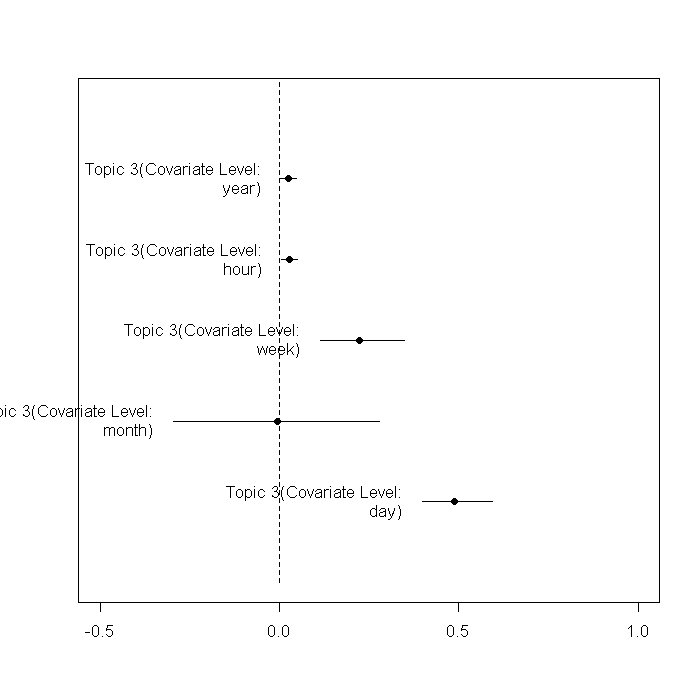

In [19]:
options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=100)
plot.estimateEffect(prep, model=model15Prrateby, covariate="rateby", topics=3, 
     method="pointestimate", 
     xlim=c(-.5,1))

We can basically infer that for offers related to topic 3 the rate tend to be computed by day rather than by other factors. As mentioned at the beginning, other covariates might offer more insightful results, and rateby was selected just for simplicity reasons. 

## Conclusions

In this document we have seen some diagnostic techniques to select a number of topics for a stm model, and gave overview of the main functions offered by the stm R package. There are a number of additional add-on packages and functions that allow further analysis, but we will explore them in a latter stage. Some of them are mentioned in the paragraph below.

Based on the results of this work, we identified a model with 15 topics as a good fit, but we also concluded that we should re-run the model on a corpus from where more stopwords are excluded. We will proceed in this way in the next entry of this series, where we will give some more depth to our analysis. In particular, we will include further variables to the analysis, explore the use of topical content co-variates, and focus more on topic correlations.


spatial analysis?
other variables
topical content
correlations
interactions

### References and helpful resources

We recomend to read in detail the <a href="https://cran.r-project.org/web/packages/stm/vignettes/stmVignette.pdf"> package vignette</a>, where some of the functions used here are presented in more detail. The theoretical aspects of the model are explained in more detail in <a href="https://scholar.princeton.edu/sites/default/files/bstewart/files/stm.pdf">Roberts et al., "A model of text for experimentation in the social sciences", 2016</a>. The <a href="https://www.structuraltopicmodel.com/"> website </a> of the authors of the model and the package offers an extensive repository of resources, including supporting packages for analysis and visualization,  as well as a list of scientific articles adopting stm. 
Julia Silge has authored two interesting posts (<a href="https://juliasilge.com/blog/sherlock-holmes-stm/">one</a> and <a href="https://juliasilge.com/blog/evaluating-stm//">two</a>) where stm is used adopting tidy data principles.


### Appendix
The procedure below has been used by Julia Silge to obtain the distribution of document probabilities per each topic, in fashion similar to <span style="font-family:Courier">plot.STM</span> with "hist" as argument. It might be helpful if using a tidy data approach, or wants to have a higher degree of control on the visualization.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


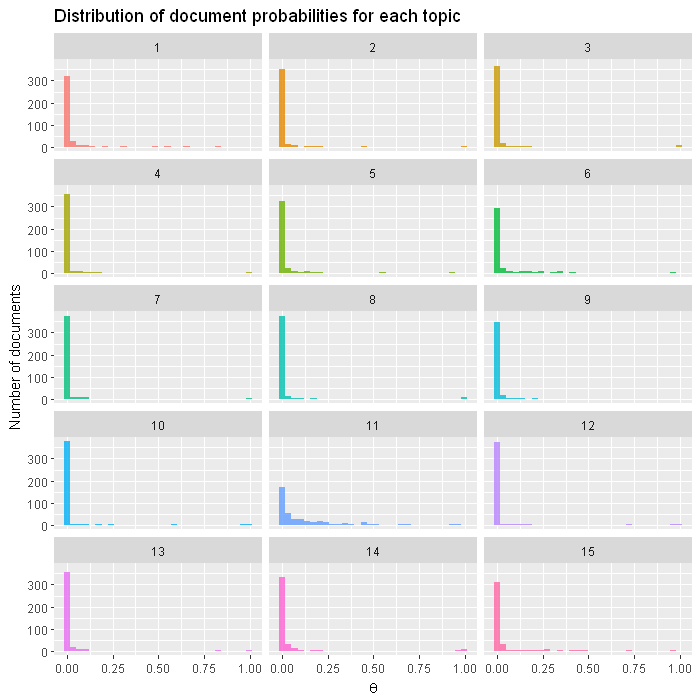

In [20]:
ggplot(td_theta, aes(gamma, fill = as.factor(topic))) +
  geom_histogram(alpha = 0.8, show.legend = FALSE) +
  facet_wrap(~ topic, ncol = 3) +
  labs(title = "Distribution of document probabilities for each topic",
       y = "Number of documents", x = expression(theta))
